In [19]:
def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(max(0,min(1,np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))))

We consider a deferred annuit with complete payback of remaining premium as a waiver against a regulare premium.
This means that a policyholder is entitled to get back the sum of the paid premium minus the sum of the paid out annuities in case of death, as long as this sum is positive. Typically this is considered as three distinct parts: a) the deferred annuity ($LA$), b) the death benefit before payout of annuityies ($LD_1$) and c) the death benefit after the withdrawal has started ($LD_2$).

In our concrete example we assume the following

\begin{enumerate}
\item Man, age 30, start of withdrawal at age 65, we sell this product in the year $t=2024$
\item Annuity $R=60000$, prenumerado payable
\item Technical interest rate 2\%, $\omega=110$
\item Mortality as per $qx(x,t) =e^{a_0 +a_1 x +a_2 x^2 + a_3 t}$
\end{enumerate}

The parmaters for $a$ are given by  a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]

{\bf Tasks}

\begin{enumerate}
\item Calculate the Premium for this insurance, and split the premium into the three benefits
\item Calculate the mathematical reserve for the ages 30,40,50,65,70,75,85
\item Calculate the Risk premium by type in tabular form for the above ages
\item Assuming that the above mortality is second order (ie best estimate), propose a mortality table which has a 10\% margin
\item Discuss the construction of such a first order table in case of most policyholder taking out policies between 30 and 65
\end{enumerate}

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Markov:
    def __init__(self,bCPP=True):
        self.bCPP = bCPP
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.iStart = None
        self.iStop  = None
        self.iNrTimesPerPeriod = 1.
        self.bRecalculateTime = False
        self.psymM = None
    
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        #print("..",self.iNrStates,self.iMaxTime)
        try:
            import markovlv as mlv
            if self.bCPP:
                self.psymM = mlv.MARKOVLV(self.iMaxTime,self.iMaxTime,1)
                self.psymM.vSetNrStates(iNrStates)
                return()
        except:
            print("Falling Back")
        for i in range(iMaxTime):
                tempPij = np.zeros([iNrStates,iNrStates])
                tempPost = np.zeros([iNrStates,iNrStates])
                tempPre = np.zeros([iNrStates])
                tempDK = np.zeros([iNrStates])
                tempCF = np.zeros([iNrStates])
                self.dPij.append(tempPij)
                self.dPost.append(tempPost)
                self.dPre.append(tempPre)
                self.dDK.append(tempDK)
                self.dCF.append(tempCF)         
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
    
    def vSetDiscount(self,fIRate):
        self.dITech=fIRate
        vTemp = 1./(1.+fIRate)
        #print("Discount %.4f"%(vTemp))
        #print (self.iMaxTime, len(self.dv))
        for i in range(self.iMaxTime):
            if self.psymM:
                for j in range(self.iNrStates):
                    self.psymM.dSetDisc(i, j, j, vTemp)
            else:
                self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPij(t,i,j,fValue)
        else:
            self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPre(t,i,j,fValue)
        else:
            self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPost(t,i,j,fValue)
        else:
            self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def pymBlowMeUp(self,iNrTimesPerPeriod,DefaultStateMapper = dict()):
        psymM = Markov()
        psymM.vDefineModel(self.iNrStates,iMaxTime=self.iMaxTime*iNrTimesPerPeriod)
        psymM.iNrTimesPerPeriod = iNrTimesPerPeriod
        psymM.bRecalculateTime = False
        self.vDoBlowUpStates(psymM,DefaultStateMapper) #To be done ie adjustment of v, P_ij, Pre and Post
        return(psym)
    
    def vDoBlowUpStates(self,psymM,DefaultStateMapper):
        for i in range(self.iNrStates):
            if i not in DefaultStateMapper.keys():
                print("Use %d to itself as default mapper"%(i))
                DefaultStateMapper[i] = i
        fIRate = 1./self.dv[0] - 1.
        psymM.vSetDiscount(fIRate)
        for t in range(self.iMaxTime):
            t0 = self.iMaxTime *self.iNrTimesPerPeriod
            t1 = t0 + self.iNrTimesPerPeriod
            for i in range(self.iNrStates):
                x=[t0*1,t1*1]
                y=[self.dPre[t][i],self.dPost[t][i,i]]
                newval = np.interp(list(range(t0,t1+1))*1., x, y)
                dPDefault  = 1.
                PTemp = np.zeros(self.iNrStates)
                for l in range(self.iNrStates):
                    if l == DefaultStateMapper[i]: continue
                    dTemp = self.dPij[t][i,l] / self.iNrTimesPerPeriod
                    dPDefault  -= dTemp
                    PTemp[l] = dTemp
                PTemp[DefaultStateMapper[i]] = PTemp[l]  
                for k in range(t1-t0):
                    psymM.vSetPre(t0+k,i,i,newval[k])
                    psymM.vSetPij(t0+k,i,l,PTemp[l])
                    for l in range(self.iNrStates):
                        if i == l: continue
                        psymM.vSetPost(t0+k,i,l,self.dPost[t][i,l])
                psymM.vSetPost(t1-1,i,i,newval[-1])
                    
    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
    
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
    
    def dGetDK(self,iStart,iStop,iAge,iState):       
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetStartTime(iStart)
            self.psymM.vSetStopTime(iStop)
            return(self.psymM.dGetDK(iAge, iState,1))
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetStartTime(iStart)
            self.psymM.vSetStopTime(iStop)
            dT = 0
            for j in range(self.iNrStates):
                dT+=self.psymM.dGetCF(iAge, iState, j)
            return(dT)
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def PrintDKs(self,iStart,iStop):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            if self.bRecalculateTime: 
                strTemp += " %6.3f :"%(i*1./self.iNrTimesPerPeriod)
            for j in range(self.iNrStates):
                 strTemp += "   %10.4f  "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        if self.bRecalculateTime: 
        #    iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        x = []
        y = []
        for i in range(iStop,iStart+1):
            if self.bRecalculateTime:
                x.append(i*1./self.iNrTimesPerPeriod)
            else:
                x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotCFs(self,iStart,iStop,figNr=2):
        if self.bRecalculateTime: 
        #    iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        import matplotlib.colors as mcolors
        A= []
        for i in mcolors.TABLEAU_COLORS.keys():
            A.append(i)
        for i in mcolors.BASE_COLORS.keys():
            A.append(i)
        
        xBar =[]
        hBar =[]
        bBar =[]
        cBar =[]
        y = []
        for i in range(iStop,iStart+1):
            for j in range(self.iNrStates):
                xBar.append(i+(0.5+j)*0.9/self.iNrStates)
                hBar.append(self.dGetCF(iStart,iStop,i,j))
                bBar.append(0)
                cBar.append(A[j])
            
        plt.figure(figNr)
        plt.bar(xBar,hBar,bottom=bBar, width = 0.9/self.iNrStates,color=cBar)
        plt.grid(True)

In [22]:
x = 30
s = 65
R = float(input("Annuity"))
iT = 0.02
t0 = 2024
omega = 110

ppM = []
for i in range(4):
    psymB = Markov()
    psymB.vDefineModel(2,iMaxTime=200)
    psymB.vSetDiscount(iT)
    ppM.append(psymB)
for i in range(x,omega):
    qx = Qx(0,i,t0+i-x)
    px = 1. - qx
    for p in ppM:
        p.vSetPij(i,0,0,px)
        p.vSetPij(i,0,1,qx)
        #print(i, px, qx)
    if i < 65:
        ppM[0].vSetPre(i,0,0,1)
        ppM[2].vSetPost(i,0,1,i-x+1)
    else:
        ppM[1].vSetPre(i,0,0,R)
        
def ppM_3(ppM,Prem,R):
    L0 = (s-x) * Prem - R
    for i in range(s,omega):
        #print(i, L0)
        ppM[3].vSetPost(i,0,1,L0)
        L0 -= R
        if L0 < 0: break
        

def CalcPremium():
    P=ppM[1].dGetDK(omega,x,x,0)/ppM[0].dGetDK(omega,x,x,0)
    for i in range(10):
        ppM_3(ppM,P,R)
        PT = (ppM[1].dGetDK(omega,x,x,0)+P*ppM[2].dGetDK(omega,x,x,0)+ppM[3].dGetDK(omega,x,x,0))/ppM[0].dGetDK(omega,x,x,0)
        print("%.3f --> %.3f"%(P, PT))
        P = PT
    return(P)

P = CalcPremium()
#for p in ppM:
#    p.PrintDKs(omega,x)

LBW = ppM[0].dGetDK(omega,x,x,0)

P1 =  ppM[1].dGetDK(omega,x,x,0) / LBW
P2 = P*ppM[2].dGetDK(omega,x,x,0) / LBW
P3 = ppM[3].dGetDK(omega,x,x,0)/ LBW

print(P1,P2,P3,P-(P1+P2+P3))

Annuity 60000


23695.715 --> 25288.510
25288.510 --> 25465.205
25465.205 --> 25485.052
25485.052 --> 25487.281
25487.281 --> 25487.531
25487.531 --> 25487.559
25487.559 --> 25487.563
25487.563 --> 25487.563
25487.563 --> 25487.563
25487.563 --> 25487.563
23695.715338624574 950.0555644802262 841.7920422655076 -1.6685589798726141e-07


In [23]:
Ages = [30,40,50,65,70,75,85,95]
for i in Ages:
    V1 = ppM[1].dGetDK(omega,i,i,0)
    V2 = P*ppM[2].dGetDK(omega,i,i,0)
    V3 = ppM[3].dGetDK(omega,i,i,0)
    VP = - P*ppM[0].dGetDK(omega,i,i,0)
    V = V1+V2 +V3 +VP
    print("%3d: V1:%10.2f V2:%10.2f V3:%10.2f VP:%10.2f V:%10.2f"%(i,V1,V2,V3,VP,V))

 30: V1: 594873.39 V2:  23850.84 V3:  21132.92 VP:-639857.15 V:      0.00
 40: V1: 729207.08 V2:  28318.02 V3:  25905.14 VP:-498686.80 V: 284743.44
 50: V1: 899609.06 V2:  29634.67 V3:  31958.68 VP:-328405.11 V: 632797.30
 65: V1:1271883.79 V2:      0.00 V3:  45183.77 VP:     -0.00 V:1317067.55
 70: V1:1128060.01 V2:      0.00 V3:  25869.00 VP:     -0.00 V:1153929.01
 75: V1: 982519.18 V2:      0.00 V3:   7647.81 VP:     -0.00 V: 990167.00
 85: V1: 697854.61 V2:      0.00 V3:      0.00 VP:     -0.00 V: 697854.61
 95: V1: 441114.14 V2:      0.00 V3:      0.00 VP:     -0.00 V: 441114.14


In [24]:
xx =[]
y1 =[]
y2 =[]
y3 =[]
for i in range(x,110):
    qx = Qx(0,i,t0+i-x)
    VP1 = - P1*ppM[0].dGetDK(omega,x,i,0)
    VP1P = - P1*ppM[0].dGetDK(omega,x,i+1,0)
    VP2 = - P2*ppM[0].dGetDK(omega,x,i,0)
    VP2P = - P2*ppM[0].dGetDK(omega,x,i+1,0)
    VP3 = - P3*ppM[0].dGetDK(omega,x,i,0)
    VP3P = - P3*ppM[0].dGetDK(omega,x,i+1,0)
    V1 = ppM[1].dGetDK(omega,x,i,0) + VP1
    V2 = P*ppM[2].dGetDK(omega,x,i,0) + VP2
    V1P = ppM[1].dGetDK(omega,x,i+1,0) + VP1P
    V2P = P*ppM[2].dGetDK(omega,x,i+1,0) + VP2P
    if i < s:
        SAR2 = P*(i-x+1)
        SAR3 = 0
    else:
        SAR2=0
        SAR3 = max(0,(s-x)*P - (i-s+1)*R)
    #print(i,VP3,VP3P)
    V3 = ppM[3].dGetDK(omega,x,i,0) + VP3
    V3P = ppM[3].dGetDK(omega,x,i+1,0) + VP3P
    #print(i,V3,V3P,SAR3,qx,P,R)
    RP1 = -qx * (V1P) /(1+iT)
    SP1 = (V1P) /(1+iT) - (V1)
    RP2 =  qx * (SAR2-V2P) /(1+iT)
    SP2 = V2P /(1+iT) - V2
    RP3 =  qx * (SAR3-V3P) /(1+iT)
    SP3 = V3P /(1+iT) - V3
    RP = RP1+RP2+RP3
    SP = SP1+SP2+SP3
    #print(V1, V2, V3, V1+V2+V3)
    xx.append(i)
    y1.append(RP)
    y2.append(SP)
    y3.append(RP+SP)
    if i in Ages:
        print("%3d: SAR1:%10.3f SAR2:%10.3f"%(i,SAR2,SAR3))
        print("%3d: RP1:%10.3f PR2:%10.3f PR3:%10.3f RP:%10.3f"%(i,RP1,RP2,RP3,RP))
        print("%3d: SP1:%10.3f SR2:%10.3f SR3:%10.3f SP:%10.3f"%(i,SP1,SP2,SP3,SP))
        print( "----> RP:%10.2f  SP:%10.2f  Sum:%10.3f\n"%(RP,SP,RP+SP)) 
    


 30: SAR1: 25487.563 SAR2:     0.000
 30: RP1:    -9.212 PR2:     9.345 PR3:    -0.327 RP:    -0.194
 30: SP1: 23704.928 SR2:   940.710 SR3:   842.119 SP: 25487.757
----> RP:     -0.19  SP:  25487.76  Sum: 25487.563

 40: SAR1:280363.192 SAR2:     0.000
 40: RP1:  -239.427 PR2:   218.662 PR3:    -8.506 RP:   -29.271
 40: SP1: 23935.143 SR2:   731.393 SR3:   850.298 SP: 25516.834
----> RP:    -29.27  SP:  25516.83  Sum: 25487.563

 50: SAR1:535238.822 SAR2:     0.000
 50: RP1: -1106.006 PR2:   906.300 PR3:   -39.291 RP:  -238.997
 50: SP1: 24801.721 SR2:    43.755 SR3:   881.083 SP: 25726.560
----> RP:   -239.00  SP:  25726.56  Sum: 25487.563

 65: SAR1:     0.000 SAR2:832064.703
 65: RP1: -7111.789 PR2:     0.000 PR3:  4521.970 RP: -2589.819
 65: SP1:-52888.211 SR2:     0.000 SR3: -4521.970 SP:-57410.181
----> RP:  -2589.82  SP: -57410.18  Sum:-60000.000

 70: SAR1:     0.000 SAR2:532064.703
 70: RP1: -9396.426 PR2:     0.000 PR3:  4361.553 RP: -5034.872
 70: SP1:-50603.574 SR2:     0.

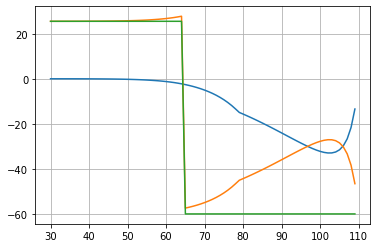

In [6]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(xx,y1,xx,y2,xx,y3)
plt.grid(True)

In [7]:
xx=110
t =2024 + (110-30)
print(xx,t, Qx(0,xx,t,param =[]))

110 2104 0.24885795798880653


In [8]:
vx = 0
for i in range(109,84,-1):
    xx= i
    t =2024 + (i-30)
    px = 1- Qx(0,xx,t)
    vx = 1 + px /1.02 *vx
    print(i,t,px,vx)

109 2103 0.7718108396772982 1.0
108 2102 0.7907315737567236 1.775227033094827
107 2101 0.808054635950046 2.4063533666236476
106 2100 0.8239172682432041 2.9437608747611694
105 2099 0.8384447304714526 3.419785091383859
104 2098 0.8517513626870556 3.8556927565520382
103 2097 0.8639415519421878 4.265777631282177
102 2096 0.8751106122085367 4.659830661232183
101 2095 0.8853455853485246 5.044667161170206
100 2094 0.894725970322136 5.425092863461007
99 2093 0.9033243871507279 5.804528123648727
98 2092 0.9112071815585194 6.185419325320704
97 2091 0.9184349756678378 6.56951514465323
96 2090 0.9250631696302947 6.958055394752098
95 2089 0.931142398628202 7.3519023431935
94 2088 0.9367189492742138 7.751633566747889
93 2087 0.9418351390686432 8.157608704261921
92 2086 0.9465296622395143 8.570018246595254
91 2085 0.9508379049869664 8.988919799306576
90 2084 0.9547922328782587 9.41426549641521
89 2083 0.9584222528896856 9.845923084682255
88 2082 0.9617550523648226 10.283692423420195
87 2081 0.9648154